# JLab May 2019 Lunch Challenge

https://halldweb.jlab.org/talks/ML_lunch/May2019/

## Problems with my model:

At the very bottom, one will see the % error and difference between true and predicted, may be just because it is not trained well, but the difference is fairly large...

## Pre-processing; gathering data

### Retreiving data from site

In [ ]:
! mkdir TRAIN
! wget https://halldweb.jlab.org/talks/ML_lunch/May2019/TRAIN/images.raw.gz
! wget https://halldweb.jlab.org/talks/ML_lunch/May2019/TRAIN/track_parms.csv
! mv images.raw.gz TRAIN
! mv track_parms.csv TRAIN
! mkdir VALIDATION
! wget https://halldweb.jlab.org/talks/ML_lunch/May2019/VALIDATION/images.raw.gz
! wget https://halldweb.jlab.org/talks/ML_lunch/May2019/VALIDATION/track_parms.csv
! mv images.raw.gz VALIDATION
! mv track_parms.csv VALIDATION

--2020-10-08 17:58:39--  https://halldweb.jlab.org/talks/ML_lunch/May2019/TRAIN/images.raw.gz
Resolving halldweb.jlab.org (halldweb.jlab.org)... 129.57.64.128
Connecting to halldweb.jlab.org (halldweb.jlab.org)|129.57.64.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31813265 (30M) [application/x-gzip]
Saving to: ‘images.raw.gz’

images.raw.gz       100%[===================>]  30.34M  9.26MB/s    in 3.3s    

2020-10-08 17:58:43 (9.26 MB/s) - ‘images.raw.gz’ saved [31813265/31813265]

--2020-10-08 17:58:43--  https://halldweb.jlab.org/talks/ML_lunch/May2019/TRAIN/track_parms.csv
Resolving halldweb.jlab.org (halldweb.jlab.org)... 129.57.64.128
Connecting to halldweb.jlab.org (halldweb.jlab.org)|129.57.64.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38940211 (37M) [text/csv]
Saving to: ‘track_parms.csv’

track_parms.csv     100%[===================>]  37.14M  9.94MB/s    in 3.7s    

2020-10-08 17:58:48 (9.94 MB/s) - ‘track_

### All required imports

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from scipy.stats import norm


### Setting up function to create generator for images

In [ ]:
import os
import sys
import gzip
import pandas as pd
import math

width  = 36
height = 100

# Open labels files so we can get number of samples and pass the
# data frames to the generators later
traindf = pd.read_csv('TRAIN/track_parms.csv')
valdf = pd.read_csv('VALIDATION/track_parms.csv')
STEP_SIZE_TRAIN = len(traindf)/32
STEP_SIZE_VAL = len(valdf)/32

#-----------------------------------------------------
# generate_arrays_from_file
#-----------------------------------------------------
# Create generator to read in images and labels
# (used for both training and validation samples)
def generate_arrays_from_file( labelsdf , dType):

	images_path = dType+'images.raw.gz'
	print( 'generator created for: ' + images_path)

	batch_input           = []
	batch_labels_phi      = []
	batch_labels_z        = []
	idx = 0
	ibatch = 0
	while True:  # loop forever, re-reading images from same file
		with gzip.open(images_path) as f:
			while True: # loop over images in file
			
				# Read in one image
				bytes = f.read(width*height)
				if len(bytes) != (width*height): break # break into outer loop so we can re-open file
				data = np.frombuffer(bytes, dtype='B', count=width*height)
				pixels = np.reshape(data, [width, height, 1], order='F')
				pixels_norm = np.transpose(pixels.astype(np.float) / 255., axes=(1, 0, 2) )
				
				# Labels
				phi = labelsdf.phi[idx]
				z   = labelsdf.z[idx]
				idx += 1

				# Add to batch and check if it is time to yield
				batch_input.append( pixels_norm )
				batch_labels_phi.append( phi )
				batch_labels_z.append( z )
				if len(batch_input) == 32 :
					ibatch += 1
					
					# Since we are training multiple loss functions we must
					# pass the labels back as a dictionary whose keys match
					# the layer their corresponding values are being applied to.
					labels_dict = {
						'phi_output' :  np.array(batch_labels_phi ),
						'z_output'   :  np.array(batch_labels_z   ),		
					}
					
					yield ( np.array(batch_input), labels_dict )
					batch_input      = []
					batch_labels_phi = []
					batch_labels_z   = []

			idx = 0
			f.close()


## Model building

### Building the model

Begins with one branch and outputs a common 32 node output.  
Then splits into 2, one for phi another for z;
First phi is completed, then concatenated to the z branch.

#### Testing model

In [ ]:
# Commented Default model, currently Edited Model
def buildBranch(input):
  x = keras.layers.Conv2D(32,(3,3),activation='relu')(input)
  x = keras.layers.BatchNormalization()(x)
  # x = keras.layers.Dropout(0.2)(x)

  x = keras.layers.Dense(128,activation='relu')(x)
  x = keras.layers.Dense(64,activation='relu')(x)
  x = keras.layers.Dense(32,activation='relu')(x)
  
  # x = keras.layers.Dropout(0.25)(x)
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(32, activation="linear",name="common_out")(x)
  return x

def buildPhiBranch(branch):
  # x = keras.layers.Dense(64, activation='relu', name="phi_dense1")(branch)
  # x = keras.layers.Dropout(0.2)(x)
  # x = keras.layers.Dense(128, activation='relu', name="phi_dense2")(x)
  # x = keras.layers.Dropout(0.2)(x)
  # x = keras.layers.Dense(64, activation='relu', name="phi_dense3")(x)

  x = keras.layers.Dense(64, activation='relu', name="phi_dense3")(branch)
  x = keras.layers.Dense(1,activation="linear",name="phi_output")(x)
  return x

def buildZBranch(branch, arg):
  x = keras.layers.concatenate([branch,arg])
  # x = keras.layers.Dense(64, activation='relu', name="z_dense1")(x)
  # x = keras.layers.Dropout(0.2)(x)
  # x = keras.layers.Dense(128, activation='relu', name="z_dense2")(x)
  # x = keras.layers.Dropout(0.2)(x)
  # x = keras.layers.Dense(128, activation='relu', name="z_dense3")(x)
  x = keras.layers.Dense(32, activation='relu', name="z_dense4")(x)
  x = keras.layers.Dense(1,activation="linear",name="z_output")(x)
  return x

In [ ]:
# Model 1
def buildBranch(input):
  x = keras.layers.Conv2D(64,(3,3),activation='relu')(input)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv2D(32,(3,3),activation='relu')(x)
  x = keras.layers.BatchNormalization()(x)
  # x = keras.layers.Dropout(0.2)(x)

  x = keras.layers.Flatten()(input)
  x = keras.layers.Dense(16, activation="relu",name="common_out")(x)
  return x

def buildPhiBranch(branch):
  # x = keras.layers.Dense(16, activation='relu', name="phi_dense1")(branch)
  # x = keras.layers.Dense(1,activation="linear",name="phi_output")(x)
  x = keras.layers.Dense(1,activation="linear",name="phi_output")(branch)
  return x

def buildZBranch(branch, arg):
  x = keras.layers.concatenate([branch,arg])
  # x = keras.layers.Dense(16, activation='relu', name="z_dense1")(x)
  x = keras.layers.Dense(1,activation="linear",name="z_output")(x)
  return x

In [ ]:
# Simple model
def buildBranch(input):
  x = keras.layers.Flatten()(input)
  x = keras.layers.Dense(16, activation="relu",name="common_out")(x)
  return x

def buildPhiBranch(branch):
  x = keras.layers.Dense(1,activation="linear",name="phi_output")(branch)
  return x

def buildZBranch(branch, arg):
  x = keras.layers.concatenate([branch,arg])
  x = keras.layers.Dense(1,activation="linear",name="z_output")(x)
  return x

In [ ]:
# AdvZ Simple model
def buildBranch(input):
  x = keras.layers.Flatten()(input)
  x = keras.layers.Dense(16, activation="relu",name="common_out")(x)
  return x

def buildPhiBranch(branch):
  x = keras.layers.Dense(1,activation="linear",name="phi_output")(branch)
  return x

def buildZBranch(branch, arg):
  x = keras.layers.concatenate([branch,arg])
  x = keras.layers.Dense(32, activation="relu",name="z_dense")(x)
  x = keras.layers.Dense(128, activation="relu",name="z_dense1")(x)
  x = keras.layers.Dense(16, activation="relu",name="z_dense2")(x)
  x = keras.layers.Dense(1,activation="linear",name="z_output")(x)
  return x

In [ ]:
# Weired...
def buildBranch(input):
  x = keras.layers.Dense(16, activation="relu",name="common_out")(input)
  # x = keras.layers.Flatten()(input)
  return x

def buildPhiBranch(branch):
  x = keras.layers.Conv2D(16,(3,3),activation='relu')(branch)
  x = keras.layers.Flatten()(branch)
  x = keras.layers.Dense(1,activation="linear",name="phi_output")(x)
  return x

def buildZBranch(branch, arg):
  x = keras.layers.Conv2D(16,(3,3),activation='relu')(branch)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Flatten()(x)
  x = keras.layers.concatenate([x,arg])
  x = keras.layers.Dense(32, activation="relu",name="z_dense1")(x)
  x = keras.layers.Dense(128, activation="relu",name="z_dense2")(x)
  x = keras.layers.Dense(16, activation="relu",name="z_dense3")(x)
  x = keras.layers.Dense(1,activation="linear",name="z_output")(x)
  return x

In [ ]:
# Testing
def buildBranch(input):
  x = keras.layers.Dense(16, activation="relu",name="common_out")(input)
  # x = keras.layers.Flatten()(input)
  return x

def buildPhiBranch(x):
  x = keras.layers.Conv2D(16,(3,3),activation='relu')(x) # ?????
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(1,activation="linear",name="phi_output")(x)
  return x

def buildZBranch(x, arg):
  x = keras.layers.Flatten()(x)
  x = keras.layers.concatenate([x,arg])
  x = keras.layers.Dense(64, activation="relu",name="z_dense1")(x) # try removing some dense layers or lowering...
  x = keras.layers.Dense(256, activation="relu",name="z_dense2")(x)
  x = keras.layers.Dense(64, activation="relu",name="z_dense3")(x)
  x = keras.layers.Dense(1,activation="linear",name="z_output")(x)
  return x

In [ ]:
# Model-2
def buildBranch(input):
  x = keras.layers.Conv2D(32,(6,3),strides=(6,1),activation="relu")(input)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(16, activation="relu",name="common_out")(x)
  return x

def buildPhiBranch(x):
  x = keras.layers.Dense(1,activation="linear",name="phi_output")(x)
  return x

def buildZBranch(x, arg):
  x = keras.layers.concatenate([x,arg])
  x = keras.layers.Dense(64, activation="relu",name="z_dense1")(x)
  x = keras.layers.Dense(256, activation="relu",name="z_dense2")(x)
  x = keras.layers.Dense(1,activation="linear",name="z_output")(x)
  return x

#### Most optimal so far

In [ ]:
# 
def buildBranch(input):
  x = keras.layers.Dense(16, activation="relu",name="common_out")(input)
  # x = keras.layers.Flatten()(input)
  return x

def buildPhiBranch(branch):
  x = keras.layers.Conv2D(16,(3,3),activation='relu')(branch)
  x = keras.layers.Flatten()(branch)
  x = keras.layers.Dense(1,activation="linear",name="phi_output")(x)
  return x

def buildZBranch(branch, arg):

  x = keras.layers.concatenate([x,arg])
  x = keras.layers.Dense(1,activation="linear",name="z_output")(x)
  return x



### Compile Model

In [ ]:
inputs = keras.Input(shape=(100, 36, 1))
branch = buildBranch(inputs)
branch_phi = buildPhiBranch(branch)
branch_z = buildZBranch(branch,branch_phi)
model = keras.Model(inputs=inputs, outputs={"phi_output":branch_phi,"z_output":branch_z}, name="detector")
losses = {
    "phi_output":"mse",
    "z_output":"mse"
}
loss_weights = {
    "phi_output":1/10.5,
    "z_output":1/7.5
}
model.compile(optimizer="adam", loss=losses, loss_weights=loss_weights, metrics=["mae"])
# model.compile(optimizer="adam", loss=losses, metrics=["mae"])
model.summary()

Model: "detector"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 36, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 34, 32)   608         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 34, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 17408)        0           batch_normalization[0][0]        
___________________________________________________________________________________________

### Create train and validation data generators for the model fit

In [ ]:
train_generator = generate_arrays_from_file(traindf,"TRAIN/")
val_generator = generate_arrays_from_file(valdf,"VALIDATION/")

### Fit model and save as "model.keras"

In [ ]:
H = model.fit(x=train_generator,
              validation_data=val_generator,
              steps_per_epoch=100,
              validation_steps=20,
              epochs=100,
              verbose=2
)
model.save("model.keras",save_format="h5")
model.save("drive/My Drive/model.keras",save_format="h5")

generator created for: TRAIN/images.raw.gz
Epoch 1/100
generator created for: VALIDATION/images.raw.gz
100/100 - 1s - loss: 2.5972 - phi_output_loss: 1.6756 - z_output_loss: 18.2822 - phi_output_mae: 0.8016 - z_output_mae: 3.6711 - val_loss: 5.4764 - val_phi_output_loss: 30.9689 - val_z_output_loss: 18.9521 - val_phi_output_mae: 4.7500 - val_z_output_mae: 3.7906
Epoch 2/100
100/100 - 1s - loss: 1.4558 - phi_output_loss: 0.7097 - z_output_loss: 10.4117 - phi_output_mae: 0.6503 - z_output_mae: 2.5180 - val_loss: 5.8328 - val_phi_output_loss: 32.9762 - val_z_output_loss: 20.1913 - val_phi_output_mae: 4.9877 - val_z_output_mae: 3.8844
Epoch 3/100
100/100 - 1s - loss: 0.8935 - phi_output_loss: 0.5131 - z_output_loss: 6.3349 - phi_output_mae: 0.5649 - z_output_mae: 1.8338 - val_loss: 5.0065 - val_phi_output_loss: 28.7042 - val_z_output_loss: 17.0454 - val_phi_output_mae: 4.6065 - val_z_output_mae: 3.5758
Epoch 4/100
100/100 - 1s - loss: 0.6524 - phi_output_loss: 0.4050 - z_output_loss: 4.603

In [ ]:
import pickle
# np.save("drive/My Drive/history",H.history)
# pickle.dump(H.history,"drive/My Drive/history")

with open('drive/My Drive/history.pkl', 'wb') as output:
    pickle.dump(H.history, output, pickle.HIGHEST_PROTOCOL)



# import csv

# w = csv.writer(open("output.csv", "w"))
# for key, val in H.history.items():
#     w.writerow([key, val])

## Post processing

### Create graphs to show loss and mae of training and validation data

dict_keys(['loss', 'phi_output_loss', 'z_output_loss', 'phi_output_mae', 'z_output_mae', 'val_loss', 'val_phi_output_loss', 'val_z_output_loss', 'val_phi_output_mae', 'val_z_output_mae'])


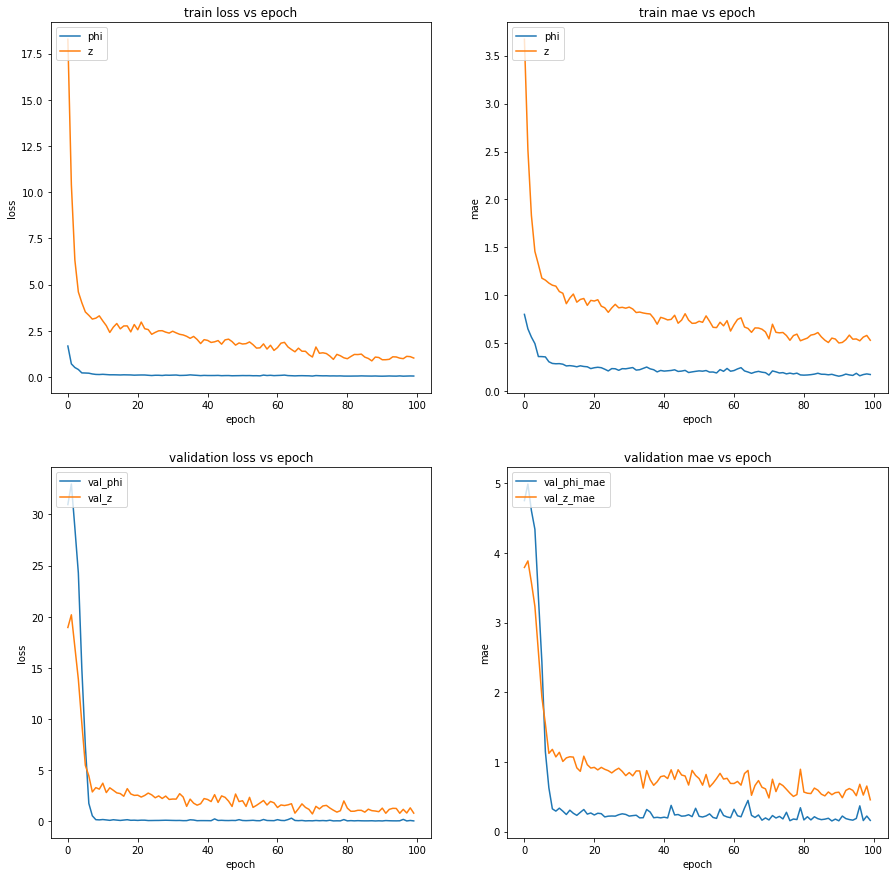

In [ ]:
print(H.history.keys())
try:
  fig, axs = plt.subplots(2,2,figsize=(15,15))


  axs[0,0].plot(H.history['phi_output_loss'])
  axs[0,0].plot(H.history['z_output_loss'])
  axs[0,0].set_title('train loss vs epoch')
  axs[0,0].set_ylabel('loss')
  axs[0,0].set_xlabel('epoch')
  axs[0,0].legend(['phi','z'],loc='upper left')

  axs[0,1].plot(H.history['phi_output_mae'])
  axs[0,1].plot(H.history['z_output_mae'])
  axs[0,1].set_title('train mae vs epoch')
  axs[0,1].set_ylabel('mae')
  axs[0,1].set_xlabel('epoch')
  axs[0,1].legend(['phi','z'],loc='upper left')

  axs[1,0].plot(H.history['val_phi_output_loss'])
  axs[1,0].plot(H.history['val_z_output_loss'])
  axs[1,0].set_title('validation loss vs epoch')
  axs[1,0].set_ylabel('loss')
  axs[1,0].set_xlabel('epoch')
  axs[1,0].legend(['val_phi','val_z'],loc='upper left')

  axs[1,1].plot(H.history['val_phi_output_mae'])
  axs[1,1].plot(H.history['val_z_output_mae'])
  axs[1,1].set_title('validation mae vs epoch')
  axs[1,1].set_ylabel('mae')
  axs[1,1].set_xlabel('epoch')
  axs[1,1].legend(['val_phi_mae','val_z_mae'],loc='upper left')



  '''
  fig1, axs1 = plt.subplots(2,2,figsize=(15,15))

  # plt.plot(H.history['phi_output_loss'])
  # plt.plot(H.history['z_output_loss'])
  # plt.title('model')
  # plt.ylabel('loss')
  # plt.xlabel('epoch')
  # plt.legend(['phi','z'],loc='upper left')
  # plt.show()


  axs1[0,0].plot(H.history['phi_output_loss'][5:])
  axs1[0,0].plot(H.history['z_output_loss'][5:])
  axs1[0,0].set_title('train loss vs epoch')
  axs1[0,0].set_ylabel('loss')
  axs1[0,0].set_xlabel('epoch')
  axs1[0,0].legend(['phi','z'],loc='upper left')

  axs1[0,1].plot(H.history['phi_output_mae'][5:])
  axs1[0,1].plot(H.history['z_output_mae'][5:])
  axs1[0,1].set_title('train mae vs epoch')
  axs1[0,1].set_ylabel('mae')
  axs1[0,1].set_xlabel('epoch')
  axs1[0,1].legend(['phi','z'],loc='upper left')

  axs1[1,0].plot(H.history['val_phi_output_loss'][5:])
  axs1[1,0].plot(H.history['val_z_output_loss'][5:])
  axs1[1,0].set_title('validation loss vs epoch')
  axs1[1,0].set_ylabel('loss')
  axs1[1,0].set_xlabel('epoch')
  axs1[1,0].legend(['val_phi','val_z'],loc='upper left')

  axs1[1,1].plot(H.history['val_phi_output_mae'][5:])
  axs1[1,1].plot(H.history['val_z_output_mae'][5:])
  axs1[1,1].set_title('validation mae vs epoch')
  axs1[1,1].set_ylabel('mae')
  axs1[1,1].set_xlabel('epoch')
  axs1[1,1].legend(['val_phi_mae','val_z_mae'],loc='upper left')
  '''

except e:
  print("error:")
  print(e)

### Create test data generator and clear arrays used for histograms


In [ ]:
test_generator = generate_arrays_from_file(valdf,"VALIDATION/")
diff_phi = np.array([])
diff_phi_err = np.array([])
diff_z = np.array([])
diff_z_err = np.array([])
z_t = np.array([])
phi_t = np.array([])
z_e = np.array([])
phi_e = np.array([])


### Graph histograms of test data

generator created for: VALIDATION/images.raw.gz
100/100 [==============================] - 1s 5ms/step - loss: 0.1372 - phi_output_loss: 0.0443 - z_output_loss: 0.9977 - phi_output_mae: 0.1605 - z_output_mae: 0.4926


(-1.5, 1.5)

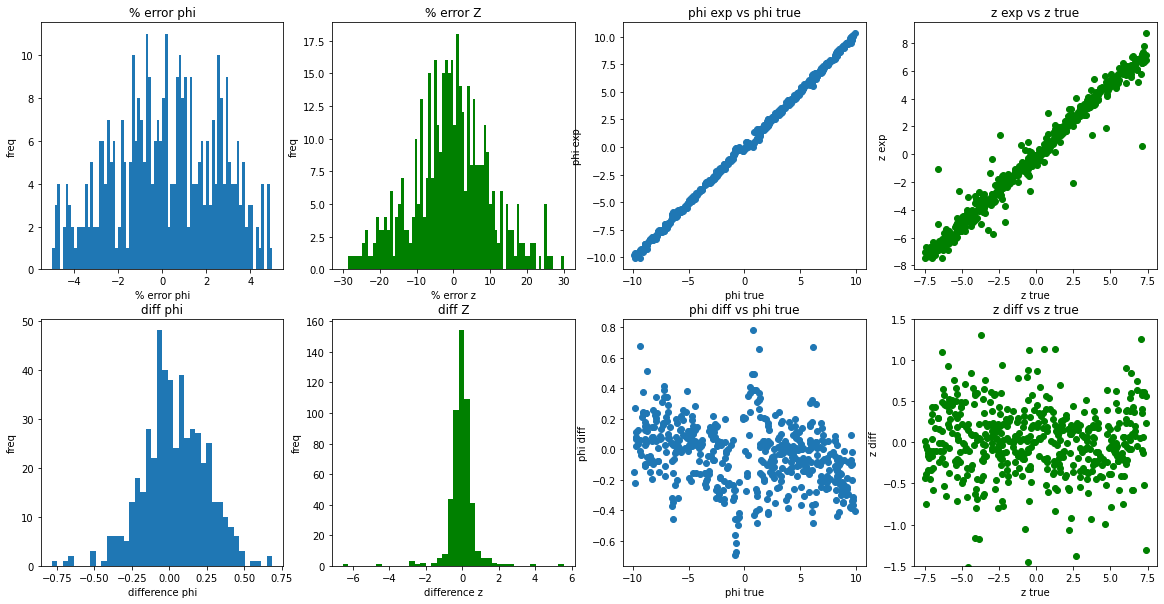

In [ ]:
ev = model.evaluate(test_generator,steps=100,batch_size=32)

for i in range(20):
  test = next(test_generator)
  test = np.array(test)
  test_x = test[0]
  test_y = test[1]

  pred = model.predict(x=test_x,verbose=0)

  prt = False

  # diff_phi = []
  # diff_phi_err = []
  # diff_z = []
  # diff_z_err = []

  if prt: print("phi:::\n")
  for i in range(25):
    true = np.reshape(test_y["phi_output"],[32,1])[i]
    exp = pred["phi_output"][i]
    phi_t = np.append(phi_t,true)
    phi_e = np.append(phi_e,exp)

    diff_phi = np.append(diff_phi,exp-true)
    diff_phi_err = np.append(diff_phi_err,((abs(exp-true)/true)*100))

    if prt: print(exp," : ",true," : ",diff_phi[-1])

  if prt: print("\n\nz::::\n")
  for i in range(25):
    true = np.reshape(test_y["z_output"],[32,1])[i]
    exp = pred["z_output"][i]
    z_t = np.append(z_t,true)
    z_e = np.append(z_e,exp)

    diff_z = np.append(diff_z,exp-true)
    diff_z_err = np.append(diff_z_err,((abs(exp-true)/true)*100))

    if prt: print(exp," : ",true," : ",diff_z[-1])

  # plt.hist(diff_phi_err,20,[-100,100])
  # plt.title('% error phi')
  # plt.ylabel('freq')
  # plt.xlabel('% error phi')
  # plt.show()


val = np.array([diff_phi,diff_phi_err,diff_z,diff_z_err,z_t,phi_t,z_e,phi_e])


if False:
  with open("drive/My Drive/data.pkl","wb") as output:
    pickle.dump(val, output, pickle.HIGHEST_PROTOCOL)


fig, axs = plt.subplots(2,4,figsize=(20,10))

# axs[0,0].hist(diff_phi_err,80,[-100,100])
axs[0,0].hist(diff_phi_err,80,[-5,5])
axs[0,0].set_title('% error phi')
axs[0,0].set_ylabel('freq')
axs[0,0].set_xlabel('% error phi')

# axs[0,1].hist(diff_z_err,80,[-100,100],color='g')
axs[0,1].hist(diff_z_err,80,[-30,30],color='g')
axs[0,1].set_title('% error Z')
axs[0,1].set_ylabel('freq')
axs[0,1].set_xlabel('% error z')

axs[1,0].hist(diff_phi,40)
axs[1,0].set_title('diff phi')
axs[1,0].set_ylabel('freq')
axs[1,0].set_xlabel('difference phi')

axs[1,1].hist(diff_z,40,color='g')
axs[1,1].set_title('diff Z')
axs[1,1].set_ylabel('freq')
axs[1,1].set_xlabel('difference z')


axs[0,2].scatter(phi_t,phi_e)
axs[0,2].set_title('phi exp vs phi true')
axs[0,2].set_ylabel('phi exp')
axs[0,2].set_xlabel('phi true')

axs[0,3].scatter(z_t,z_e,color='g')
axs[0,3].set_title('z exp vs z true')
axs[0,3].set_ylabel('z exp')
axs[0,3].set_xlabel('z true')

axs[1,2].scatter(phi_t, phi_t-phi_e)
axs[1,2].set_title('phi diff vs phi true')
axs[1,2].set_ylabel('phi diff')
axs[1,2].set_xlabel('phi true')

axs[1,3].scatter(z_t, z_t-z_e,color='g')
axs[1,3].set_title('z diff vs z true')
axs[1,3].set_ylabel('z diff')
axs[1,3].set_xlabel('z true')
axs[1,3].set_ylim([-1.5,1.5])


f, ax = plt.subplots(1,2,figsize=(10,5))

(mu, sigma) = norm.fit(diff_phi)
_, bins, _ = ax[0].hist(diff_phi, 60, facecolor="blue", alpha=0.75, density=True)
y = norm.pdf(bins, mu, sigma)
l = ax[0].plot(bins, y, 'r--', linewidth=2)

ax[0].set_xlabel('phi diff')
ax[0].set_ylabel('Probability')
ax[0].set_title("Difference of $\phi$: $\mu={mu:.3f}$, $\sigma={sigma:.3f}$".format(mu=mu, sigma=sigma))
ax[0].grid(True)


# Cut large and small data, limit data to middle

for index in range(len(diff_z)):
  if index >= len(diff_z):
    break
  if abs(diff_z[index]) > 2:
    # print("cutting : ", index)
    diff_z = np.append(diff_z[0:index],diff_z[index+1:])
    index-=1

(mu, sigma) = norm.fit(diff_z)
_, bins, _ = ax[1].hist(diff_z, 60, facecolor="green", alpha=0.75, density=True)
y = norm.pdf(bins, mu, sigma)
l = ax[1].plot(bins, y, 'r--', linewidth=2)

ax[1].set_xlabel('z diff')
ax[1].set_ylabel('Probability')
ax[1].set_title("Difference of $z$: $\mu={mu:.3f}$, $\sigma={sigma:.3f}$".format(mu=mu, sigma=sigma))
ax[1].grid(True)

for index in range(len(diff_z)):
  if abs(diff_z[index]) > 2:
    print("found one at",index)



